# IMPORTING NECESSARY LIBRARIES

In [20]:
# Import necessary libraries
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16


In [21]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76


# BLOK SIMILARITY SCORING BASED FEATURES VECTOR
In this section, we will copy the pre-trained model vgg16 except the last layer to obtain features vector of each image

In [3]:
# 1. Download pre-trained model vgg16
# include_top = True, means that we are going to use fully layer include dense last layer to classifiy image
# usually pre-trained architecture mode consist of convolutional layer as feature extractor and dense layer as classifier based on pattern 
model = VGG16(weights="imagenet", include_top=True)
model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [4]:
# 2. Define function to convert image to array
def load_image(image_path):
    img = image.load_img(image_path, target_size=model.input_shape[1:3])
    array_img = image.img_to_array(img)
    array_img = np.expand_dims(array_img, axis=0)
    array_img = preprocess_input(array_img)

    return img, array_img

In [5]:
# 3. Create the feature extractor object
# for inputs paramater, we use the VGG16 model input without modified it
# for outputs paramater as the last layer, we use the fc2 layer, without including the predictions dense layer  
feature_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feature_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 134,260,544
Trainable params: 134,260,544
Non-trainable params: 0
_________________________________________________________________


In [6]:
# 4. Collect all features vector from all images in folder 
# First, get the number of total image and each filename as image path in folder   
images_path = '/content/drive/MyDrive/data_img_retrieval/RuangTamu/'
image_extensions = ['.jpg', '.png', '.jpeg']
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if len(images) > max_num_images:
  images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d image to analyze" % len(images))

keeping 514 image to analyze


In [8]:
# Second, walk through of each image, 
# extract it's feature vector using predict method, 
# then accumulate to features variable
features = []

for i, image_path in enumerate(images):
    img, array = load_image(image_path)
    img_feature = feature_extractor.predict(array)[0]
    features.append(img_feature)


In [10]:
# 5. Using PCA, we could reduce the features size to become smaller
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components = 100)
pca.fit(features)

pca_features = pca.transform(features)


In [11]:
print(pca_features)

[[ 16.141693     1.8563733   -0.7095517  ...   1.6566525   -2.3893664
    0.17078924]
 [ 14.259283     0.763503   -22.276718   ...  -0.43993565   1.0279065
   -1.2570584 ]
 [  6.2331157    6.403651     5.994296   ...   1.6648545    0.96920574
   -0.3798849 ]
 ...
 [ -1.6945615   34.8466       0.27974418 ...   4.912994     7.4239035
   -2.973677  ]
 [ 19.677881     4.2481256   -0.4672358  ...   0.74841607  -1.5959995
    0.4331492 ]
 [ -9.8755245   -6.520182   -10.910181   ...   0.48341534  -6.147988
   -3.5692754 ]]


# COLOR FILTER SECTION 

In [15]:
# 1.2 Define function to extract color using K Means Clustering
# It will return the top number_of_colors from an image in RGB  
def color_extraction(image, number_of_colors):
  
  # Resize image to smaller image in order to reduce further execution time
  modified_image = cv2.resize(image, (600, 400), interpolation= cv2.INTER_AREA)

  # flattened image from 3D to 2D
  modified_image = modified_image.reshape((modified_image.shape[0] * modified_image.shape[1]), 3)

  clf = KMeans(n_clusters=number_of_colors)
  labels = clf.fit_predict(modified_image)
  # print(labels) -> [0 0 0 ... 1 1 1]

  jumlahLabels = Counter(labels)
  # print('jumlahLabels: ', jumlahLabels) -> jumlahLabels:  Counter({0: 172678, 1: 67322})

  center_colors = clf.cluster_centers_
  # print(center_colors)
  # [[183.79379229 159.77189976 133.50193629]
  # [ 83.64274986  50.52329472  37.03554062]]  

  ordered_colors = [center_colors[i] for i in jumlahLabels.keys()]
  # print(ordered_colors)
  # [array([183.79278069, 159.76989911, 133.49961507]), array([83.63641231, 50.51868652, 37.0328966 ])]

  rgb_colors = [ordered_colors[i] for i in jumlahLabels.keys()]
  # print(rgb_colors)
  # [array([183.79127717, 159.76803172, 133.49765288]), array([83.63133784, 50.51373541, 37.02932996])]

  return rgb_colors


In [23]:
# 1.3 Define a function that decide the two image similarities by calculating extracted rgb2lab data
# remember, extracted rgb colors from an image return the most number of colors from an image
# then we will looping through those data and compare (calculate) one by one 
def image_color_similarities(query_image_path, reference_image_path, number_of_colors, threshold):

  query_image = cv2.imread(query_image_path)
  query_image = cv2.cvtColor(query_image, cv2.COLOR_RGB2BGR)
  
  reference_image = cv2.imread(reference_image_path)
  reference_image = cv2.cvtColor(reference_image, cv2.COLOR_RGB2BGR)

  query_image_color = color_extraction(query_image, number_of_colors)
  # print("Query: ", query_image_color)

  reference_image_color = color_extraction(reference_image, number_of_colors)
  # print("Reference: ", reference_image_color)

  iter = 0
  total_difference = 0

  similar = False

  for idx_queries in range(number_of_colors):
    for idx_references in range(number_of_colors):
      curr_color_query = rgb2lab(np.uint8(np.asarray([[query_image_color[idx_queries]]])))
      curr_color_reference = rgb2lab(np.uint8(np.asarray([[reference_image_color[idx_references]]])))
  
      # print('------------------------>')
      # print(curr_color_query)
      # print(curr_color_reference)

      difference = deltaE_cie76(curr_color_query, curr_color_reference)
      # print(difference)

      total_difference = total_difference + difference
      iter = iter + 1;

  
  average_diff = total_difference / iter
  # print(average_diff)

  if (average_diff <= threshold):
    similar = True
  else:
    similar = False

  return similar

# BLOK TESTING QUERY IMAGE

In [73]:
# 6. Take random image data as query for similarity
import random

query_image_idx = int(len(images) * random.random())
query_image = image.load_img(images[query_image_idx])

In [74]:
# 7. Calculate the similar images based on cosine distance
# then it will return the all image with its similarity scoring
from scipy.spatial import distance
similarity_scoring = [distance.cosine(pca_features[query_image_idx], feature) for feature in pca_features]

print(similarity_scoring)

[0.8383598178625107, 0.8688478767871857, 1.2054645419120789, 1.1544560343027115, 1.2177725285291672, 1.107842467725277, 0.9422848783433437, 0.979792095720768, 1.0322586223483086, 0.8592594116926193, 1.0648180842399597, 0.9781054891645908, 1.0831164419651031, 1.1041754186153412, 1.022086925804615, 0.8348692655563354, 0.5067116618156433, 1.1138252541422844, 1.1240286231040955, 0.6252303719520569, 1.0478728041052818, 0.8742726892232895, 0.9734982643276453, 1.117280326783657, 1.1921132951974869, 0.5761193335056305, 0.8968397155404091, 0.995148878544569, 0.8969677686691284, 0.7509227842092514, 1.1784885674715042, 0.9444785453379154, 0.7400027513504028, 1.3431239128112793, 1.0482279285788536, 0.8866171613335609, 0.966242603957653, 0.9158359989523888, 0.6957309544086456, 1.349551498889923, 1.280744880437851, 1.0685875117778778, 0.6335303783416748, 0.8736110031604767, 1.1490418463945389, 1.165390208363533, 0.8196522742509842, 0.9746878072619438, 0.843951478600502, 1.201055571436882, 1.37411332

In [75]:
# 8. Sort the similarity scoring in 5 range of best closest distance
# below, we take 5 most similar images, actualy 0 is not included, because it will referes to query image itself 
# this function will return most the id of closes similar images
num = len(similarity_scoring)
closest_similar_images = sorted(range(num), key=lambda k: similarity_scoring[k])[1:11] 

In [76]:
print(closest_similar_images)

[395, 151, 16, 25, 333, 67, 406, 428, 274, 19]


In [77]:
# 9. Visualize all the closest similar images
thumbnails = []

for i in closest_similar_images:
    img = image.load_img(images[i])

    # match two filtered images based on color 
    is_color_similar = image_color_similarities(images[query_image_idx], images[i], 2, 30)
    if (is_color_similar):
      # img = img.resize(int(image.width * 100 / image.height), 100)
      img = img.resize((100, 100))
      thumbnails.append(img)

concat_image = np.concatenate([np.asarray(t) for t in thumbnails], axis=1)

query images


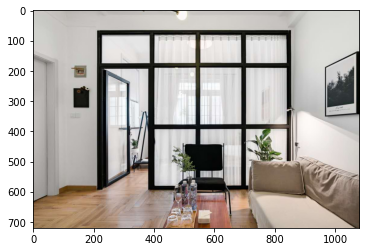

In [78]:
print('query images')
plt.imshow(query_image)

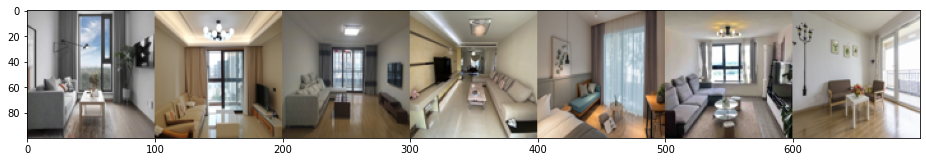

In [79]:
plt.figure(figsize = (16,12))
plt.imshow(concat_image)